# L3: Building an Autonomous Web Agents

Note: The images and code snippets are taken from the "Building AI Browser" course by deeplearning.ai

What our agent will be doing: 
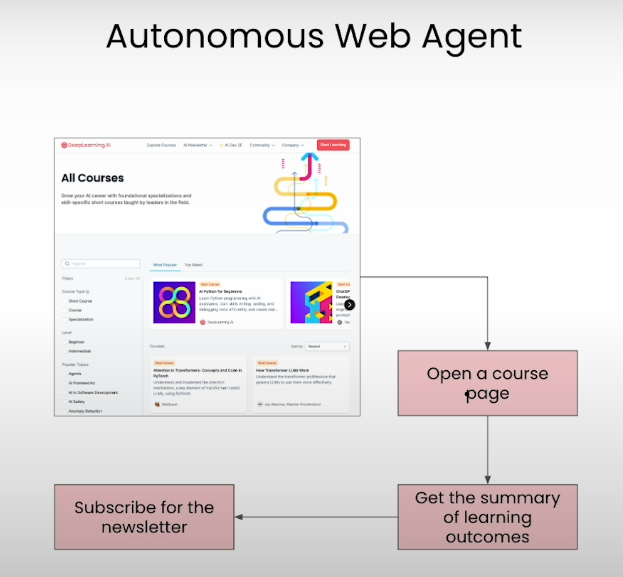

<p style="background-color:#fff6e4; padding:15px; border-width:3px; border-color:#f5ecda; border-style:solid; border-radius:6px"> ⏳ <b>Note <code>(Kernel Starting)</code>:</b> This notebook takes about 30 seconds to be ready to use. You may start and watch the video while you wait.</p>

## MultiOn Web Agent

In [1]:
import os  # For environment variable access
from multion.client import MultiOn  # MultiOn client SDK for interacting with the automation agent


from utils import (get_multi_on_api_key,       # Function to securely retrieve the MultiOn API key
                    visualizeSession,          # Utility to render session screenshot/output
                    MultiOnDemo,               # Class to run a full multi-step demo
                    SessionManager,            # Manages session-related logic
                    ImageUtils,                # (Assumed) utilities for image processing
                    display_step_header)       # Helper to display step headers during iteration


<div style="background-color:#fff6ff; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
<p> 💻 &nbsp; <b>Access <code>requirements.txt</code> and <code>helper.py</code> files:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Open"</em>.

<p> ⬇ &nbsp; <b>Download Notebooks:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Download as"</em> and select <em>"Notebook (.ipynb)"</em>.</p>

<p> 📒 &nbsp; For more help, please see the <em>"Appendix – Tips, Help, and Download"</em> Lesson.</p>
</div>

In [2]:
# Set up the MultiOn API Client
multion_api_key = get_multi_on_api_key()
multion = MultiOn(api_key=multion_api_key, base_url=os.getenv("DLAI_MULTION_BASE_URL")) # Initialize MultiOn client with base URL

## Multion Client

In [3]:
# A wrapper around MultiOn to simplify its usage.
class MultiOnClient:
    """A simplified client for the MultiOn API"""
    
    def __init__(self, multion):
        """Initialize the MultiOn client with the API key"""
        # Use the actual MultiOn class from the imported module
        self.client = multion
        self.session_id = None
        self.current_url = None
        self.screenshot = None
    
    # Create a New Session
    def create_session(self, url):
        """Create a new agent session"""
        session = self.client.sessions.create(url=url,
                                              include_screenshot=True)
        self.session_id = session.session_id
        self.current_url = session.url
        self.screenshot = session.screenshot
        return session
    
    def close_session(self):
        """Close the current session"""
        if self.session_id:
            self.client.sessions.close(self.session_id)
            self.session_id = None
    
    def list_sessions(self):
        """List all active sessions"""
        return self.client.sessions.list()
    
    def close_all_sessions(self):
        """Close all open sessions"""
        sessions = self.list_sessions()
        for session in sessions.session_ids:
            self.client.sessions.close(session)
    
    # Navigate to a Different URL in the Same Session
    def navigate_to_url(self, url):
        """Navigate to a URL in the current session"""
        if not self.session_id:
            return self.create_session(url)  # If session doesn't exist, create a new one
        
        response = self.client.sessions.step(
            session_id=self.session_id,
            cmd=f"GO TO URL {url}",
            include_screenshot=True,
            mode="standard"
        )
        
        self.current_url = response.url
        self.screenshot = response.screenshot
        return response

    # Execute a Text-Based Instruction on Current Page
    def execute_task(self, task):
        """Execute a task in the current agent session"""
        if not self.session_id:
            raise ValueError("No active session. Call create_session first.")
            
        response = self.client.sessions.step(
            session_id=self.session_id,
            cmd=(
                f"""IMPORTANT: DO NOT ASK THE USER ANY QUESTIONS. 
                All the necessary information is already provided 
                and is on the current Page.\n
                Complete the task to the best of your abilities.\n\n
                Task:\n\n{task}"""
            ),
            include_screenshot=True,
        )
        
        self.current_url = response.url
        self.screenshot = response.screenshot
        
        return response

In [4]:
# Instantiate Client and Create Initial Session
multionClient = MultiOnClient(multion)

## Example 1

In [5]:
# Task Definition: Instruction and URL
instruction = "get list all the courses"
url = "https://deeplearning.ai/courses"
MAX_STEPS = 10
MAX_IMAGE_WIDTH = 500

In [6]:
session = multionClient.create_session(url)

In [7]:
## Execution loop 
# Keeps sending the same instruction to improve or update the state.
step = 0
while session.status == "CONTINUE" and step < MAX_STEPS:
    display_step_header(step)
    visualizeSession(session, max_image_width=MAX_IMAGE_WIDTH)
    session = multionClient.execute_task(instruction)
    step += 1

In [8]:
visualizeSession(session, max_image_width=MAX_IMAGE_WIDTH)


## MultiOn Browser UI

In [9]:
sessionManager = SessionManager(url, multionClient)
subject = "RAG"
name = "Div Garg"
email = "info@theagi.company"
action_engine = None         # (Optional) external engine or handler for actions

# Each item in the list is a separate instruction given to the agent.
instructions = [f"Find the course on {subject} and open it",
                f"Summarize the course",
                f"Detailed course lessons",
                f"""Go to the deeplearning ai home page and subscribe 
                to the batch newsletter use the name {name}, 
                {email} choose the other required fields
                as you see fit. Make sure to select the proper dropdown
                values. Finally once you see 
                the subscribe button click it"""
               ]

In [10]:
demo = MultiOnDemo(url, 
                   sessionManager, 
                   multionClient, 
                   instructions, 
                   action_engine)

In [ ]:
demo.create_demo()